**NP problem**: In computational complexity theory, NP is a complexity class used to describe certain types of decision problems. Informally, NP is the set of all decision problems for which the instances where the answer is "yes" have efficiently verifiable proofs. More precisely, these proofs have to be verifiable by deterministic computations that can be performed in polynomial time.

Equivalently, the formal definition of NP is the set of decision problems solvable in polynomial time by a theoretical non-deterministic Turing machine. This second definition is the basis for the abbreviation NP, which stands for "nondeterministic, polynomial time." 

## Learning the tree

Because the problem is NP we can resort to a greedy construction algorithm. Greedy algorithms choose the current best binary partition without taking into account its impact on the quality of subsequent splits.

The algorithm idea is as follows:

+ Initialize the algorithm with a node associated to the full data set. 

**while** the list is not empty
1. Retrieve the first node from the list.
2. Find the data associated to that node.
3. Find a splitting point.
4. If the node is splittable, create the nodes linked to the parent node and put them in the exploration list.

#### The splitting criterion

There are many different splitting criteria. The most common ones are:

+ Misclassification error
+ Gini index
+ Cross-entropy/Information gain/Mutual information

Withouth going into details, misclassification error splits greedily select the split that corrects more data at each point. Gini index and cross-entropy probabilistically model the notion of impurity of a node. The split is chosen so that the average purity of the new nodes is maximized. Observe that as we descend in the tree the purity increases and eventually converge to pure leaves. A nice way of thinking about entropy is Pedro Domingos' simile with surprise. Entropy measures the average surprise/information a probabilistic result yields. In a binary variable, the maximum surprise occurs when both outcomes are equally probable, one has the maximum uncertainty on the result. Otherwise, the surprise decreases. This behavior is also display in Gini's index.

### 3.1.3 Trees and overfitting

Because trees are very expressive models they can model any training set perfectly and easily overfit.

There are two ways of avoiding overfitting in trees:

+ Stop growing the tree when the split is not statistically significant.
+ Grow a full tree and post-prune.

One of the simplest ways of post pruning is "reduced error prunning". It goes like this,

1. Split data into training and validation
2. Create a candidate tree on the training set
3. Do until further pruning is harmful
    1. Evaluate impact on the validation set of removing each posible node (with descendants)
    2. Greedily remove the node that improves the performance the most.
    
Pruning is not implemented in sklearn at this moment. However let us check what happens in our customer churn prediction problem when we use a decision tree.

In [1]:
from __future__ import division
import pandas as pd
import numpy as np

churn_df = pd.read_csv('churn.csv')
col_names = churn_df.columns.tolist()

print "Column names:"
print col_names

to_show = col_names[:6] + col_names[-6:]

print "\nSample data:"
churn_df[to_show].head(6)

Column names:
['State', 'Account Length', 'Area Code', 'Phone', "Int'l Plan", 'VMail Plan', 'VMail Message', 'Day Mins', 'Day Calls', 'Day Charge', 'Eve Mins', 'Eve Calls', 'Eve Charge', 'Night Mins', 'Night Calls', 'Night Charge', 'Intl Mins', 'Intl Calls', 'Intl Charge', 'CustServ Calls', 'Churn?']

Sample data:


,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,8.41,10.1,3,2.73,3,False.
5,AL,118,510,391-8027,yes,no,9.18,6.3,6,1.70,0,False.


In [2]:
# Isolate target data
churn_result = churn_df['Churn?']
y = np.where(churn_result == 'True.',1,0)

# We don't need these columns
to_drop = ['State','Phone','Churn?']
churn_feat_space = churn_df.drop(to_drop,axis=1)

# 'yes'/'no' has to be converted to boolean values
# NumPy converts these from boolean to 1. and 0. later
yes_no_cols = ["Int'l Plan","VMail Plan"]
churn_feat_space[yes_no_cols] = churn_feat_space[yes_no_cols] == 'yes'

# Pull out features for future use
features = churn_feat_space.columns

X = churn_feat_space.as_matrix().astype(np.float)

print "Feature space holds %d observations and %d features" % X.shape
print "Unique target labels:", np.unique(y)

Feature space holds 3333 observations and 18 features
Unique target labels: [0 1]


In [3]:
#Save data for future use.
import pickle
ofname = open('churn_data.pkl', 'wb')
s= pickle.dump([X,y,features],ofname)
ofname.close()

In [4]:
%reset -f #deletes all variables
#Recover Churn data
import pickle
fname = open('churn_data.pkl','rb')
data = pickle.load(fname)
X = data[0]
y = data[1]
features = data[2]
print 'Loading ok.'

Don't know how to reset  #deletes, please run `%reset?` for details
Don't know how to reset  all, please run `%reset?` for details
Don't know how to reset  variables, please run `%reset?` for details
Loading ok.


In [5]:
print X.shape
print y.shape

(3333, 18)
(3333,)


In [6]:
import numpy as np
from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn import metrics

kf = cross_validation.KFold(n =y.shape[0], n_folds=5, shuffle=False,
                            random_state=0)
#kf contains a touple of lists of index 'for train' and 'for test'. Splited randomly
score = np.zeros((5,))
i=0
yhat = y.copy()
for train_index, test_index in kf:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test =y[train_index], y[test_index]
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    dt = tree.DecisionTreeClassifier(criterion='entropy')
    dt.fit(X_train, y_train)
    X_test = scaler.transform(X_test)
    yhat[test_index] = dt.predict(X_test)
    score[i] = metrics.accuracy_score(yhat[test_index], y_test)
    i=i+1
print 'Mean accuracy: ' + str(np.mean(score))

Mean accuracy: 0.914792153473


**Scaling**: Standardize features by removing the mean and scaling to unit variance

Since the range of values of raw data varies widely, in some machine learning algorithms, objective functions will not work properly without normalization. For example, the majority of classifiers calculate the distance between two points by the Euclidean distance. If one of the features has a broad range of values, the distance will be governed by this particular feature. Therefore, the range of all features should be normalized so that each feature contributes approximately proportionately to the final distance.

Another reason why feature scaling is applied is that gradient descent converges much faster with feature scaling than without it.

Standardization of a dataset is a common requirement for many
machine learning estimators: they might behave badly if the
individual feature do not more or less look like standard normally
distributed data (e.g. Gaussian with 0 mean and unit variance).

For instance many elements used in the objective function of
a learning algorithm (such as the RBF kernel of Support Vector
Machines or the L1 and L2 regularizers of linear models) assume that
all features are centered around 0 and have variance in the same
order. If a feature has a variance that is orders of magnitude larger
that others, it might dominate the objective function and make the
estimator unable to learn from other features correctly as expected.


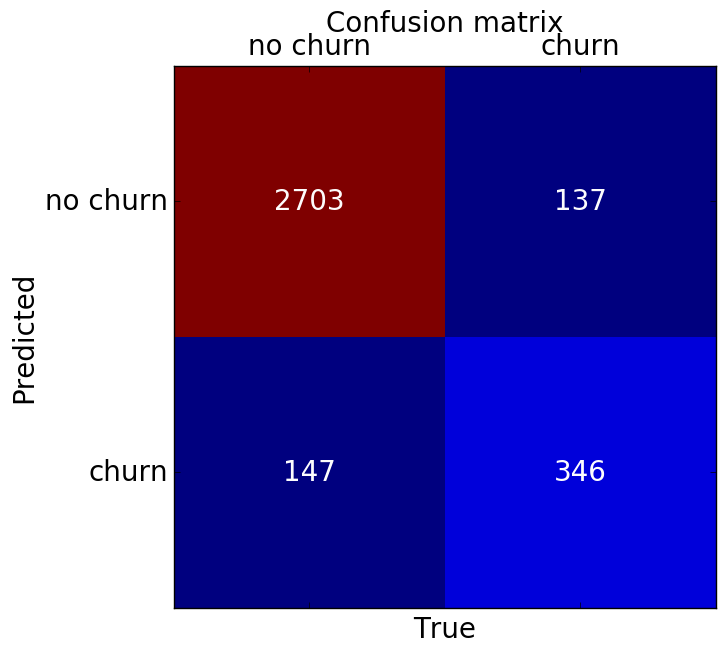

             precision    recall  f1-score   support

          0       0.95      0.95      0.95      2850
          1       0.70      0.72      0.71       483

avg / total       0.92      0.91      0.92      3333



In [7]:
import matplotlib.pyplot as plt
def draw_confusion(y,yhat,labels):
    cm = metrics.confusion_matrix(y, yhat)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.matshow(cm)
    plt.title('Confusion matrix',size=20)
    ax.set_xticklabels([''] + labels, size=20)
    ax.set_yticklabels([''] + labels, size=20)
    plt.ylabel('Predicted',size=20)
    plt.xlabel('True',size=20)
    for i in xrange(2):
        for j in xrange(2):
            ax.text(i, j, cm[i,j], va='center', ha='center',color='white',size=20)
    fig.set_size_inches(7,7)
    plt.show()

draw_confusion(y,yhat,['no churn', 'churn'])
print metrics.classification_report(y,yhat)

In [14]:
import os
#Let us check the the first three levels of the tree. GraphViz and PyDot are needed.
dt = tree.DecisionTreeClassifier(criterion='entropy', max_depth=3)
scaler = StandardScaler()
Xs = scaler.fit_transform(X)
dt.fit(Xs,y)

#Export Tree

dotfile = tree.export_graphviz(dt, out_file = "tree_churn.dot", 
                            feature_names = features)


os.system("dot -Tpng tree_churn.dot -o churn.png")


32512

In [13]:
from IPython.core.display import Image
Image("churn.png")

## EXAMPLE + Mas tutorials



Decision trees are very popular because it's easy interpretability. 

A node represents a single input variable (X) and a split point on that variable, **assuming the variable** is numeric. The leaf nodes (also called terminal nodes) of the tree contain an output variable (y) which is used to make a prediction

Creating a decision tree is a process of dividing the input space according to some criterion, in each node a splitting criteria is made over one feature. 

-All the values are lined up and different split points are tried and tested using a cost function.

The split with the lowest cost is choosen. 

Splitting continues until nodes contain a minimum number of training examples or a maximum tree depth is reached.

**Practical Example** : 

Banknote Dataset

The banknote dataset involves predicting whether a given banknote is authentic given a number of measures taken from a photograph.

The dataset contains 1,372 with 5 numeric variables. It is a classification problem with two classes (binary classification).

Below provides a list of the five variables in the dataset.

-variance of Wavelet Transformed image (continuous).

-skewness of Wavelet Transformed image (continuous).

-kurtosis of Wavelet Transformed image (continuous).

-entropy of image (continuous).

-class (integer).

In [22]:
import pandas as pd
import numpy as np

data = pd.read_csv('data_banknote_authentication.csv')

data.columns = ['variance' ,'skewness', 'kurtosis', 'entropy', 'Class']

In [25]:
print data.Class.unique()
print data.Class.describe()

[0 1]
count    1371.000000
mean        0.444931
std         0.497139
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: Class, dtype: float64


In [49]:
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn.cross_validation import KFold
from sklearn import metrics

features = ['variance' ,'skewness', 'kurtosis', 'entropy']
y = data.Class.values
X = data[features].values
scaler =StandardScaler()
kf = KFold(n=y.shape[0],n_folds=5)

score = np.zeros((5,))
i=0
yhat =y.copy()
for train_index, test_index in kf:
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    dt = tree.DecisionTreeClassifier()
    dt.fit(X_train, y_train)
    yhat[test_index]= dt.predict(X_test)
    score[i]= metrics.accuracy_score(y, yhat)
    i=i+1
print 'Mean score: ', np.mean(score)
print '\n', score

Mean score:  0.749088256747

[ 0.9190372   0.84318016  0.81692195  0.66010212  0.50619985]


0.37230917763426541